# SBS

In [127]:
import numpy as np

class SBS:
    def __init__(self, estimator, num_features, test_ratio=0.2):
        """
        Parameters
        ----------
        estimator : fit, predict メソッドを持つラベルの推定器
        num_features : 特徴量がいくつになるまで削減するか
        test_ratio : 与えられたデータのうちテストに用いる割合
        """
        self.estimator = estimator
        self.num_features = num_features
        self.test_ratio = test_ratio

    def fit(self, data, labels):
        n = len(data)
        # 学習データとテストデータに分割
        n_test = int(n * self.test_ratio)
        index_random = np.array(range(n))
        np.random.shuffle(index_random)
        data_test, data_train = data[index_random[:n_test]], data[index_random[n_test:]]
        labels_test, labels_train = labels[index_random[:n_test]], labels[index_random[n_test:]]
        # 特徴量を削っていく
        self.acc_max = []
        dim = len(data[0])
        i_features = np.array(range(dim))
        self.i_features_removed = []
        while dim > self.num_features:
            acc_max = - np.inf
            i_rm_acc_max = None
            for i_rm in i_features:
                i_features_small = np.delete(i_features, np.where(i_features == i_rm))
                self.estimator.fit(data_train[:, i_features_small], labels_train)
                acc = self.__calc_accuracy(data_test[:, i_features_small], labels_test)
                if acc_max < acc:
                    acc_max = acc
                    i_rm_acc_max = i_rm
            i_features = np.delete(i_features, np.where(i_features == i_rm_acc_max))
            self.i_features_removed.append(i_rm_acc_max)
            dim -= 1
            self.acc_max.append(acc_max)
        self.i_features = i_features

    def __calc_accuracy(self, data_test, labels_test):
        labels_predict = self.estimator.predict(data_test)
        acc = np.count_nonzero(labels_predict == labels_test) / len(labels_test)
        return acc

[9]
[[0.85947357 0.6450333  0.23951272 0.89554604 0.9756938  0.67100059
  0.52449273 0.24581938 0.9356174  0.07059605 0.47208071 0.20097438
  0.89762567 0.67813369 0.99889019]
 [0.87643921 0.2312559  0.04713889 0.93216331 0.24399013 0.73981228
  0.94970845 0.3760714  0.57840644 0.17025477 0.52611753 0.32562619
  0.37829276 0.2456892  0.06579709]
 [0.11518012 0.70294303 0.78983434 0.72046896 0.91494761 0.54909069
  0.22913547 0.87685238 0.08139212 0.5753403  0.67081237 0.56853993
  0.52368711 0.22019953 0.53254112]
 [0.54918372 0.8968484  0.79067741 0.23222427 0.06325867 0.0426957
  0.22842818 0.95769408 0.72227375 0.10449144 0.18027212 0.63352061
  0.37863744 0.19586275 0.2218174 ]
 [0.8223014  0.50023148 0.98798825 0.3531338  0.46827781 0.92609497
  0.58845188 0.26553266 0.49626201 0.59869185 0.17966892 0.37239763
  0.57989152 0.21681185 0.7936369 ]
 [0.56897223 0.47195559 0.77339345 0.73995908 0.40539447 0.02386033
  0.30058119 0.58659476 0.95287662 0.77031941 0.22857561 0.629818
  0

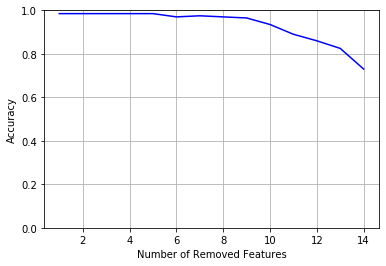

In [241]:
N = 1000

data = np.array([np.random.rand(N) for _ in range(15)]).T
labels = np.array([1 if x[0] + x[1] - 2*x[2] - 3*x[3] + 4*x[4] < 5*x[5] - 6*x[6] + 7*x[7] - 8*x[8] + 9*x[9] else -1 for x in data])

from sklearn import svm
estimator = svm.LinearSVC()
sbs = SBS(estimator, 1)
sbs.fit(data, labels)

print(sbs.i_features)
print(data[:10])
print(data[:10, sbs.i_features])
print(sbs.acc_max)
print(sbs.i_features_removed)

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
plt.ylim([0, 1])
plt.xlabel('Number of Removed Features')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(sbs.acc_max)+1)), sbs.acc_max, c='b')
plt.grid()
plt.show()

[0.00000e+00 2.12050e+00 6.97200e+00 1.34825e+01 3.36090e+01 5.05000e-01
 6.10000e-02 2.50000e-03 0.00000e+00 0.00000e+00]


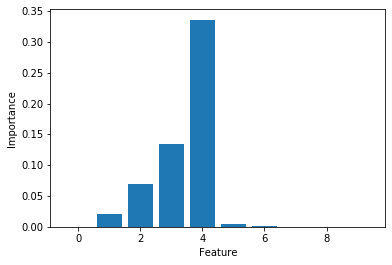

In [231]:
N_SAMPLE = 10000
TEST_RATIO = 0.2
N_FEATURE = 10
N_TREE = 100

# データを作成
data = np.array([np.random.rand(N_SAMPLE) for _ in range(N_FEATURE)]).T
labels = np.array([1 if 0.1*x[0] + x[1] + 2*x[2] + 3*x[3] < 5*x[4] + 0.7*x[5] + 0.3*x[6] else -1 for x in data])

# 特徴量の重要度を計算
from sklearn import tree
importance = np.full(N_FEATURE, 0.)
for i in range(N_TREE):
    n_test = int(N_SAMPLE * TEST_RATIO)
    index_random = np.array(range(N_SAMPLE))
    np.random.shuffle(index_random)
    data_oob, data_train = data[index_random[:n_test]], data[index_random[n_test:]]
    labels_oob, labels_train = labels[index_random[:n_test]], labels[index_random[n_test:]]
    dt = tree.DecisionTreeClassifier(min_samples_split=10)
    dt.fit(data_train, labels_train)
    acc = np.count_nonzero(dt.predict(data_oob) == labels_oob) / len(labels_oob)
    for i in range(N_FEATURE):
        data_ = data_oob.copy().T
        data_[i] = np.random.permutation(data_[i])
        data_ = data_.T
        acc_ = np.count_nonzero(dt.predict(data_) == labels_oob) / len(labels_oob)
        importance[i] += acc - acc_
for i in range(len(importance)):
    if importance[i] < 0:
        importance[i] = 0

# 結果を出力
print(importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.bar(range(N_FEATURE), importance / N_TREE)
plt.show()